<a href="https://colab.research.google.com/github/ashley-biu/iLab2/blob/main/skin_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project 6: A Deep Learning System for Differential Diagnosis of Skin Diseases

In this project, I have build a CNN based skin disease classifier using PyTorch, to classify wheather the skin is benign or malignant.

The model use a pretrained ResNet101 model as base model to extract features, and then use a classification layer to classify the skin disease. During the training process, the model will freeze the weights of the base model, and only train the classification layer (fine tuning). The reason I use a pretrained model is to reduce the time and computation cost, and also to reduce the chance of overfitting.

# I. Explore the dataset

There are 20712 images in total, 11413 benign images and 9299 malignant images.

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, models, transforms
import os
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import pandas as pd
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns
from PIL import Image

In [ ]:
# dataset path
data_dir = './skin'

In [ ]:
statistics = []
for folder in ['train', 'val', 'test']:
    for cls in ['benign', 'malignant']:
        path = os.path.join(data_dir, folder, cls)
        filenames = os.listdir(path)
        for filename in filenames:
            statistics.append({
                'Path': os.path.join(path, filename),
                'Label': cls,
                'Folder': folder,
            })
statistics = pd.DataFrame(statistics)
statistics.head()

,Path,Label,Folder
0,./skin/train/benign/ISIC_9923559.jpg,benign,train
1,./skin/train/benign/ISIC_9625423.jpg,benign,train
2,./skin/train/benign/ISIC_7641139.jpg,benign,train
3,./skin/train/benign/ISIC_6719190.jpg,benign,train
4,./skin/train/benign/ISIC_7131902.jpg,benign,train


In [ ]:
statistics.shape

(20712, 3)

In [ ]:
statistics.Label.value_counts()

,count
Label,
benign,11413
malignant,9299


In [ ]:
count = statistics.groupby(['Folder', 'Label']).count()

<Figure size 500x300 with 0 Axes>

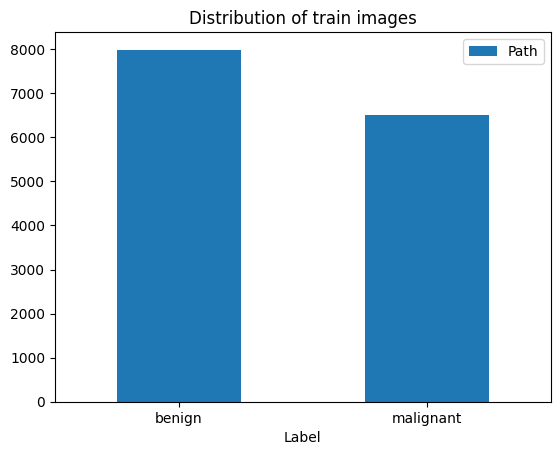

<Figure size 500x300 with 0 Axes>

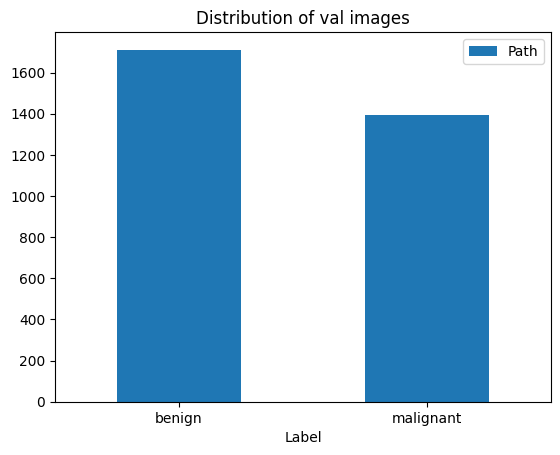

<Figure size 500x300 with 0 Axes>

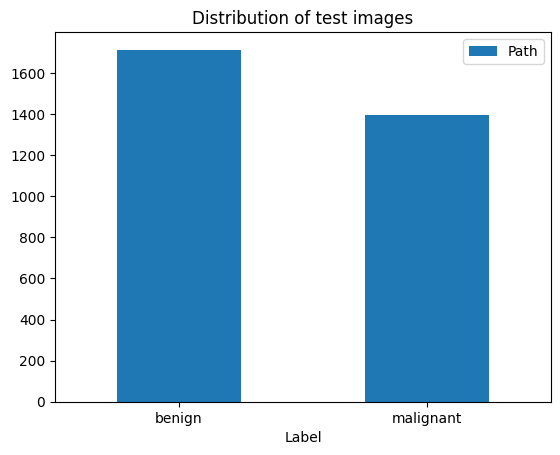

In [ ]:
for i, folder in enumerate(['train', 'val', 'test']):
    plt.figure(figsize=(5, 3))
    count.loc[folder].plot(kind='bar')
    plt.title('Distribution of {} images'.format(folder))
    plt.xticks(rotation=0)
    plt.show()

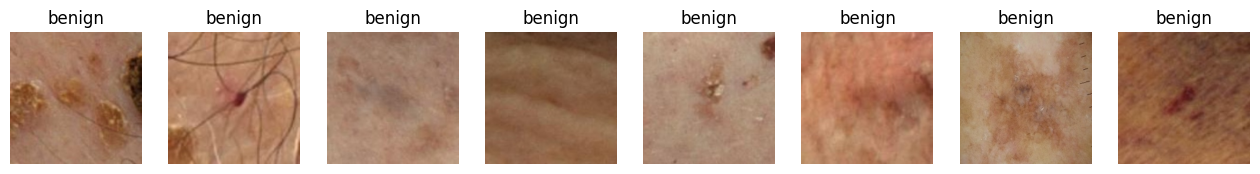

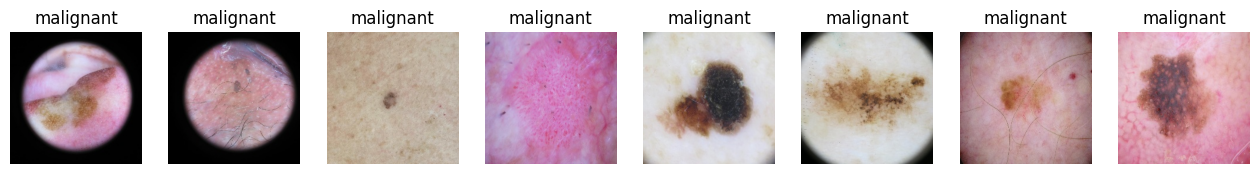

In [ ]:
# randomly pick some skin image for visualization
image_path_benign = statistics[(statistics['Folder'] == 'train') & (statistics['Label'] == 'benign')]['Path'].sample(8)
image_path_malignant = statistics[(statistics['Folder'] == 'train') & (statistics['Label'] == 'malignant')][
    'Path'].sample(8)
image_benign = [Image.open(path) for path in image_path_benign]
image_malignant = [Image.open(path) for path in image_path_malignant]
fig, axes = plt.subplots(1, 8, figsize=(16, 2))
for i, ax in enumerate(axes.flat):
    ax.imshow(image_benign[i])
    # title
    ax.set_title('benign')
    ax.axis('off')
plt.show()

fig, axes = plt.subplots(1, 8, figsize=(16, 2))
for i, ax in enumerate(axes.flat):
    ax.imshow(image_malignant[i])
    # title
    ax.set_title('malignant')
    ax.axis('off')

# II. Build CNN model

In [ ]:
# data augmentation & normalization
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}


In [ ]:
class SkinDiseaseClassifier(nn.Module):
    def __init__(self):
        super(SkinDiseaseClassifier, self).__init__()
        resnet101 = models.resnet101(pretrained=True)
        # base model: resnet101
        # freeze the weights of the resnet101 model
        self.resnet101 = nn.Sequential(*list(resnet101.children())[:-1])
        for param in self.resnet101.parameters():
            param.requires_grad = False
        # classification layer
        self.cls = nn.Sequential(
            nn.Linear(2048, 1024),
            nn.ReLU(),
            nn.Linear(1024, 2)
        )

    def forward(self, x):
        x = self.resnet101(x)
        x = x.view(x.size(0), -1)
        x = self.cls(x)
        return x

In [ ]:
# use a GPU if available
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [ ]:
# data loader
image_datasets = {
    x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
    for x in ['train', 'val', 'test']
}
dataloaders = {
    x: DataLoader(image_datasets[x], batch_size=128, shuffle=True, num_workers=2)
    for x in ['train', 'val', 'test']
}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}
class_names = image_datasets['train'].classes

In [ ]:
dataset_sizes

{'train': 14498, 'val': 3105, 'test': 3109}

In [ ]:
model = SkinDiseaseClassifier()
model = model.to(device)

# loss function
criterion = nn.CrossEntropyLoss()
# optimizer, only for the classification layer
optimizer = optim.SGD(model.cls.parameters(), lr=0.001, momentum=0.9)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to /root/.cache/torch/hub/checkpoints/resnet101-63fe2227.pth
100%|██████████| 171M/171M [00:01<00:00, 150MB/s]


## 1. Training

In [ ]:
# training
epoch_training_loss = []
epoch_training_acc = []
epoch_validation_loss = []
epoch_validation_acc = []

batch_training_loss = []
batch_validation_loss = []
num_epochs = 5

for epoch in range(num_epochs):
    print(f'Epoch {epoch + 1}/{num_epochs}')
    print('-' * 10)

    for phase in ['train', 'val']:
        if phase == 'train':
            model.train()  # set to training mode
        else:
            model.eval()   # set to evaluation mode

        epoch_running_loss = 0.0
        epoch_running_corrects = 0

        # iteration
        for inputs, labels in tqdm(dataloaders[phase]):
            inputs = inputs.to(device)
            labels = labels.to(device)

            # clear the gradient
            optimizer.zero_grad()

            # forward pass
            with torch.set_grad_enabled(phase == 'train'):
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)
                if phase == 'train':
                    batch_training_loss.append(loss.item())
                else:
                    batch_validation_loss.append(loss.item())
                # backward
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

            # compute statistics
            epoch_running_loss += loss.item() * inputs.size(0)
            epoch_running_corrects += torch.sum(preds == labels.data)

        epoch_loss = epoch_running_loss / dataset_sizes[phase]
        epoch_acc = (epoch_running_corrects.double() / dataset_sizes[phase]).item()

        print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

        if phase == 'train':
            epoch_training_loss.append(epoch_loss)
            epoch_training_acc.append(epoch_acc)
        else:
            epoch_validation_loss.append(epoch_loss)
            epoch_validation_acc.append(epoch_acc)

Epoch 1/5
----------


  0%|          | 0/114 [00:00<?, ?it/s]

train Loss: 0.4329 Acc: 0.8449


  0%|          | 0/25 [00:00<?, ?it/s]

val Loss: 0.3051 Acc: 0.9169
Epoch 2/5
----------


  0%|          | 0/114 [00:00<?, ?it/s]

train Loss: 0.2803 Acc: 0.9085


  0%|          | 0/25 [00:00<?, ?it/s]

val Loss: 0.2698 Acc: 0.9208
Epoch 3/5
----------


  0%|          | 0/114 [00:00<?, ?it/s]

train Loss: 0.2677 Acc: 0.9105


  0%|          | 0/25 [00:00<?, ?it/s]

val Loss: 0.2616 Acc: 0.9211
Epoch 4/5
----------


  0%|          | 0/114 [00:00<?, ?it/s]

train Loss: 0.2587 Acc: 0.9129


  0%|          | 0/25 [00:00<?, ?it/s]

val Loss: 0.2592 Acc: 0.9211
Epoch 5/5
----------


  0%|          | 0/114 [00:00<?, ?it/s]

train Loss: 0.2530 Acc: 0.9137


  0%|          | 0/25 [00:00<?, ?it/s]

val Loss: 0.2541 Acc: 0.9205


In [ ]:
# save model
torch.save(model.state_dict(), 'model.pth')

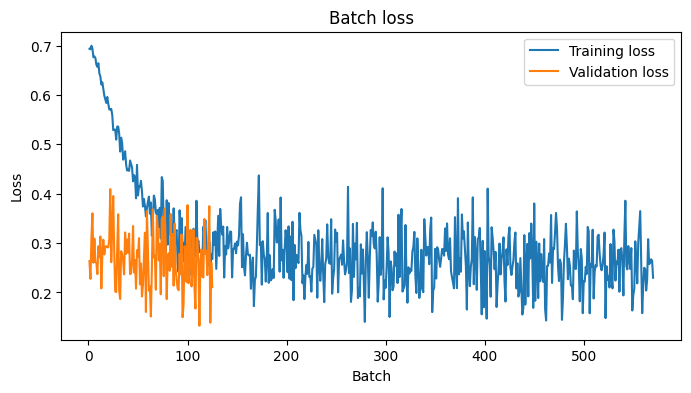

In [ ]:
# plot batch loss
plt.figure(figsize=(8, 4))
plt.title("Batch loss")
plt.plot(range(1, len(batch_training_loss) + 1), batch_training_loss, label="Training loss")
plt.plot(range(1, len(batch_validation_loss) + 1), batch_validation_loss, label="Validation loss")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.legend()

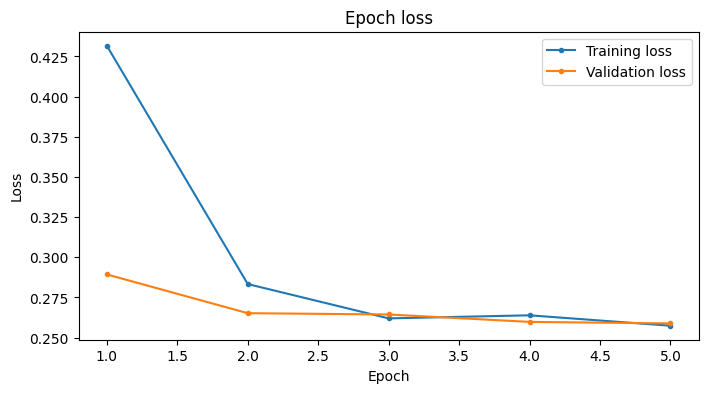

In [ ]:
# plot epoch loss
plt.figure(figsize=(8, 4))
plt.title("Epoch loss")
plt.plot(range(1, len(epoch_training_loss) + 1), epoch_training_loss, label="Training loss", marker='.')
plt.plot(range(1, len(epoch_validation_loss) + 1), epoch_validation_loss, label="Validation loss", marker='.')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

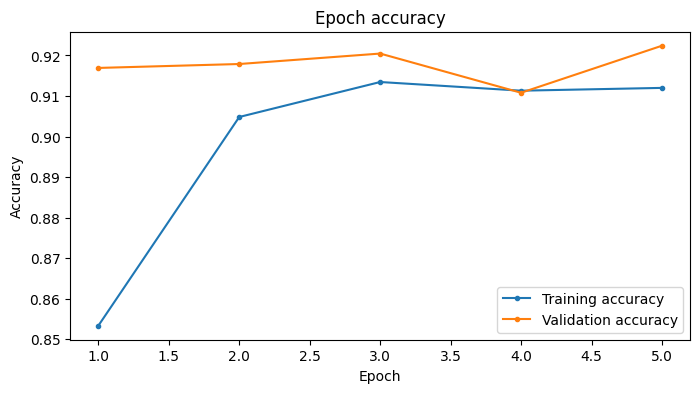

In [ ]:
# plot epoch accuracy
plt.figure(figsize=(8, 4))
plt.title("Epoch accuracy")
plt.plot(range(1, len(epoch_training_acc) + 1), epoch_training_acc, label="Training accuracy", marker='.')
plt.plot(range(1, len(epoch_validation_acc) + 1), epoch_validation_acc, label="Validation accuracy", marker='.')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

## 2. Test

In [ ]:
model.eval()
# prediction & ground truth
predictions = []
ground_truth = []
for inputs, labels in tqdm(dataloaders['test']):
    inputs = inputs.to(device)
    labels = labels.to(device)

    with torch.no_grad():
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        predictions.extend(preds.cpu().numpy())
        ground_truth.extend(labels.cpu().numpy())

In [ ]:
predictions = np.array(predictions)
ground_truth = np.array(ground_truth)

In [ ]:
# classification report

print(classification_report(ground_truth, predictions, target_names=class_names))

              precision    recall  f1-score   support

      benign       0.95      0.91      0.93      1713
   malignant       0.90      0.94      0.92      1396

    accuracy                           0.93      3109
   macro avg       0.92      0.93      0.92      3109
weighted avg       0.93      0.93      0.93      3109



In [ ]:
acc = (sum(ground_truth == predictions) / len(ground_truth)) * 100
print(f"Test accuracy: {acc:.2f}%")

Test accuracy: 92.51%


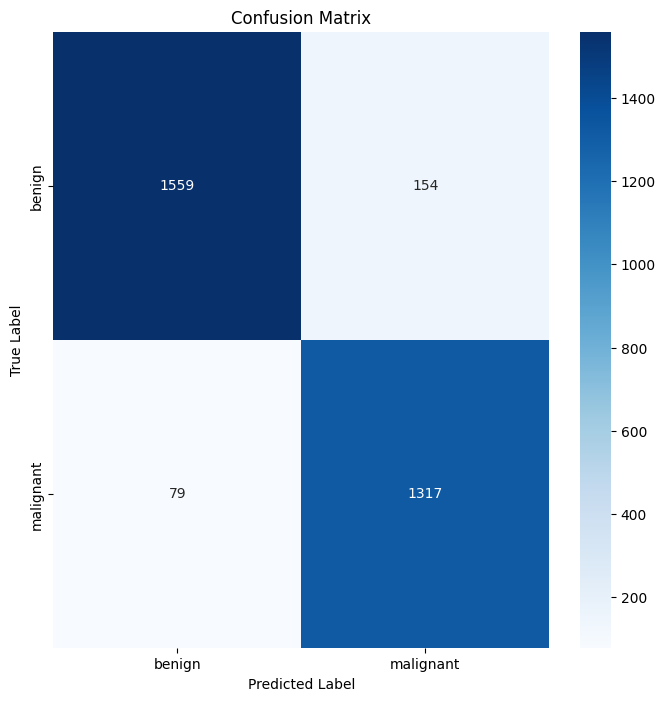

In [ ]:
# plot confusion matrix

cm = confusion_matrix(ground_truth, predictions)
plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()